In [19]:
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import scipy.stats as sts
import os
import urllib.request
import sys

np.set_printoptions(precision=5, floatmode='maxprec', suppress=True)
%matplotlib inline

In [20]:
%%time
# Находим ячейки
def find_cell (df, x='pickup_longitude', y='pickup_latitude'):
    cells = np.empty(len(df), dtype='int16')
    x = int((np.where(df.columns == x))[0])
    y = int((np.where(df.columns == y))[0])
    for i in range(len(df)):
        lon = df.iloc[i, x]
        lat = df.iloc[i, y]
        cells[i] = (int(50*np.floor((lon-MIN_LON)/D_LON) + np.floor((lat-MIN_LAT)/D_LAT))+1)
    return cells
#find_cell(data)

Wall time: 12 ms


In [21]:
# Функция для расчета нужных столбцов
def preprocess_data(df, start_date, n_hours, verbose = None):
    nrow_raw = len(df)
    index = pd.DatetimeIndex(start = start_date, freq = 'H', periods = n_hours)
    periods = {index[i]:i for i in range(len(index))}
    df['hour'] = df.tpep_pickup_datetime.dt.floor('H')
    df['trip_duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.seconds
    df['pickup_cell'] = find_cell(df)
    df['hour_num'] = pd.Series(periods[i] for i in data.tpep_pickup_datetime.dt.floor('H'))
    return (df)

In [22]:
# Функция для расчета сводной таблицы
def calulate_pivot(df, start_date, n_hours, verbose = None):
    pivot = sts.binned_statistic_2d(x=df.pickup_cell, y=df.hour_num, values=None,statistic='count', 
                                range=[[1,2501], [0,n_hours]], bins=(2500, n_hours),
                                expand_binnumbers = False)
    ind = pd.DatetimeIndex(start = start_date, freq = 'H', periods = n_hours)
    pivot = pd.DataFrame(pivot[0], index=range(1, 2501), columns=ind)
    pivot = pivot.apply(pd.to_numeric, downcast = 'unsigned')
    # Проверка для тестирования
    if verbose == 'full':
        print('Размерность сводной таблицы:',pivot.shape)
        print('Сумма элементов сводной таблицы:', pivot.sum().sum())
        print('Кол-во строк в исходных данных:', len(df))
    return pivot

In [23]:
# Функция для нахождения ячейки, в которой находится точка
def find_point_cell(lon, lat):
    try:
        return(int(50*np.floor((lon-MIN_LON)/D_LON) + np.floor((lat-MIN_LAT)/D_LAT))+1)
    except IndexError:
        return ('Not in NYC')

## Импорт данных

In [31]:
MIN_LAT = 40.49612
MAX_LAT = 40.91553
MIN_LON = -74.25559
MAX_LON = -73.70001
D_LAT = (MAX_LAT - MIN_LAT)/50.
D_LON = (MAX_LON - MIN_LON)/50.
data = pd.read_csv('data/yellow_tripdata_2016-05.csv', #nrows =100000,
                   usecols=range(7), parse_dates = ['tpep_pickup_datetime','tpep_dropoff_datetime'])

data.head()


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192


In [32]:
%%time
# Удаляем поездки без пассажиров, с нулевой длиной и длительностью
print('Было строк:', len(data))
data = data[(data.tpep_pickup_datetime != data.tpep_dropoff_datetime) &
            (data.passenger_count  != 0) &
            (data.trip_distance != 0) &
            (data.pickup_longitude >= MIN_LON) & (data.pickup_longitude <= MAX_LON) &
            (data.pickup_latitude >= MIN_LAT) & (data.pickup_latitude  <= MAX_LAT)]
print('Осталось строк:', len(data))
data.reset_index(drop=True, inplace =True  )

Было строк: 11836853
Осталось строк: 11626521
Wall time: 936 ms


In [33]:
%%time
# Находим ячейки
def find_cell (df):
    cells = (50*np.floor((data.pickup_longitude-MIN_LON)/D_LON) + np.floor((data.pickup_latitude-MIN_LAT)/D_LAT) +1).astype(int)
    return cells
find_cell(data)

Wall time: 558 ms


In [27]:
%%time
#x = 50*np.floor((data.pickup_longitude-MIN_LON)/D_LON)
#y = np.floor((data.pickup_latitude-MIN_LAT)/D_LAT)
z = 50*np.floor((data.pickup_longitude-MIN_LON)/D_LON) + np.floor((data.pickup_latitude-MIN_LAT)/D_LAT) +1
#print((x+y+1).astype(int))
z

Wall time: 10 ms


In [34]:
%%time
data = preprocess_data(data, '2016.05', 744)
pivot = calulate_pivot(data, '2016.05', 744, 'full')

Размерность сводной таблицы: (2500, 744)
Сумма элементов сводной таблицы: 11626521
Кол-во строк в исходных данных: 11626521
Wall time: 1min 9s


### График количества поездок от ESB

In [35]:
# Empire State Building coordinates
esb_lat = 40.748412
esb_long = -73.985860
esb_cell = find_point_cell(esb_long, esb_lat)
print('Cell for Empire State Building:',esb_cell)

Cell for Empire State Building: 1231


Text(0,0.5,'Trip   count')

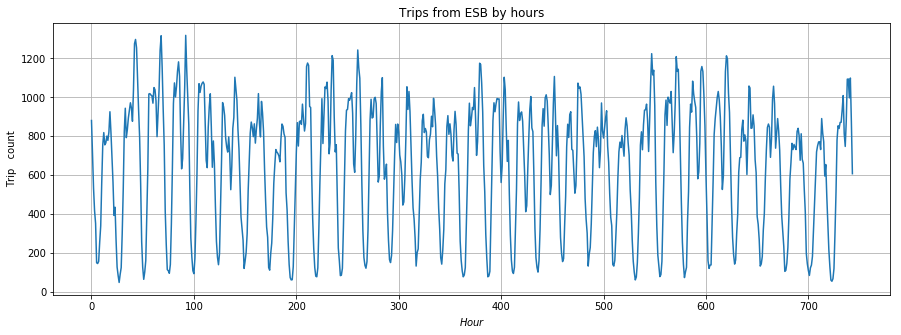

In [37]:
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(range(744), pivot.loc[esb_cell,:])#, width = 1, align = 'edge', tick_label = range(24))
plt.title('Trips from ESB by hours')
plt.xlabel('$Hour$')
plt.ylabel('Trip   count')

### Подсчет количества пар ячейка-час, из которых не было поездок

In [38]:
(pivot==0).sum().sum()

1718238

In [ ]:
pivot.to_csv('data/pivots/pivot_yellow_tripdata_2016-05')